In [3]:
import imageio
import numpy as np 
from matplotlib import pyplot as py
from scipy.stats import norm
from statistics import stdev 
from scipy.optimize import curve_fit
import pylab
from collections import defaultdict
from PIL import Image
import scipy.io
import h5py
import numba
from numba import jit


In [4]:

#Eval function 1 based on input_file.txt 
def evaluate_fit_function(wavelength, dct_to_hypers, fit_func, maxes=None):
    values_to_return = []
    iter_cone_types = ["L", "M", "S"]
    for index in range(3): 
        cone_type = iter_cone_types[index]
        a,b,c,d,e,f,g,h = dct_to_hypers[cone_type]
        val = fit_func(wavelength, a,b,c,d,e,f,g,h)
        values_to_return.append(val)
    return values_to_return

#Eval function 2 based on equation estimates for sensitivity spectra 
def evaluate_fit_function_curve2(wavelength, dct_to_hypers=None, fit_func=None, maxes=None):
    S_max, M_max, L_max = 444, 532, 564
    if maxes: 
        if maxes[0]: 
            S_max = maxes[0]
        if maxes[1]: 
            M_max = maxes[1]
        if maxes[2]: 
            L_max = maxes[2]
    
#     M_max -= 20
#     S_max, M_max, L_max = 420, 560, 600
    values_to_return = []
    values_to_return.append(L_formula(wavelength, L_max))
    values_to_return.append(M_formula(wavelength, M_max))
    values_to_return.append(S_formula(wavelength, S_max))
    return values_to_return
    

#Per cone formulas that are used in Eval function 2
def L_formula(x, wavelength_max): 
    result = (abs(x-wavelength_max)/28.5)**3.1 + 1
    return 1/result
def M_formula(x, wavelength_max): 
    result = (abs(x-wavelength_max)/41)**2.8 + 1
    return 1/result
def S_formula(x, wavelength_max): 
    result = (abs(x-wavelength_max)/52)**3.3 + 1
    return 1/result


#Error Function Number 1 - Weighted multipliers of raw differences between proposed pixel and actual pixel 
def wavelength_error_sum(evaluated_val_at_wavelength, pixel_rgb, dct_to_hypers = None, fit_func = None, override=None): 
    
    multiplier = [1,2,5]
    if override: 
        multiplier = override
    sorted_array = np.argsort(pixel_rgb)
    sum_errors = 0
    values = evaluated_val_at_wavelength
#     print([255 * value for value in values])
    for index in range(len(values)): 
        if index == sorted_array[-1]: 
            sum_errors += multiplier[-1] * (abs(values[index] - pixel_rgb[index]))
        elif index == sorted_array[-2]: 
            sum_errors += multiplier[-2] * (abs(values[index] - pixel_rgb[index]))
        else: 
            sum_errors += multiplier[-3] * (abs(values[index] - pixel_rgb[index]))                          
#         print(sum_errors)
        
    return sum_errors


#Error Function Number 2 - Difference of ratios for R-> B and G-> B between proposed pixel and actual pixel 
def wavelength_error_ratio(evaluated_val_at_wavelength, pixel_rgb, dct_to_hypers = None, fit_func = None): 

    values = evaluated_val_at_wavelength
    
    ratio_red_blue = values[0]/values[2]
    ratio_green_blue = values[1]/values[2]

    empirical_ratio_red_blue = pixel_rgb[0]/pixel_rgb[2]
    empirical_ratio_green_blue = pixel_rgb[1]/pixel_rgb[2]
    
    return abs(ratio_red_blue/empirical_ratio_red_blue) + abs(ratio_green_blue/empirical_ratio_green_blue)





#-----------------------------------------------------------------------------------------------------------------------

#Set Error Function and Eval Function up here 



#Find wavelength that maps closest to given pixel value 
def find_closest_wavelength(wavelength_axis, pixel_rgb, eval_function, error_function, dct_to_hypers=None, fit_func=None): 
    minError = None 
    best_wavelength = None
    for wavelength in wavelength_axis: 
        
        sum_errors = error_function(eval_function(wavelength), pixel_rgb, dct_to_hypers, fit_func)
            
        if not minError or sum_errors < minError: 
            best_wavelength = wavelength
            minError = sum_errors
    return best_wavelength
    
#Read in  image
def read_in_image(image_name): 

    im = imageio.imread(image_name, pilmode='RGB')
    print(im.shape)
    return im

#Bring rgb values into range [0,1]
def normalize_RGB(rgb): 
    return [x/255 for x in rgb]







            
#Remap pixel from RGB space to spectral space (Incorporates all previous functions) 
def remap_pixel(wavelength_axis, pixel_rgb, eval_function, error_function, 
                dct_to_hypers=None, dct_to_hypers_shifted=None, fit_func = None): 
        best_wavelength = find_closest_wavelength(wavelength_axis, 
                                                  normalize_RGB(pixel_rgb),
                                                  dct_to_hypers, 
                                                  fit_func)
        new_values = eval_function(best_wavelength, dct_to_hypers_shifted, fit_func)
        new_values = np.asarray(new_values)
#         print(255*new_values)
        return 255*new_values

def check_int(s):
    s = str(s)
    if s[0] in ('-', '+'):
        return s[1:].isdigit()
    return s.isdigit()  

#Loads input_file.txt into 2D numpy array 
def clean_data(txt_file): 
    with open(txt_file) as f: 
        lines = [line.rstrip('\n') for line in f]

    split_lines = []
    for line in lines: 
        temp_array = line.split(" ")
        # print(temp_array)
        to_add = []
        
        for item in temp_array: 
            # print("{} {} {}".format(item, check_int(item), to_add))
            if check_int(item) and len(to_add) > 0:

                split_lines.append(to_add)
                to_add = []
                to_add.append(item)
            else: 
                to_add.append(item)
        if to_add: 
            split_lines.append(to_add)

#     print(split_lines)
    for row in split_lines: 
        for rowIndex in range(len(row)):
            if ord(row[rowIndex][0]) in [8722, 8211] : 
                row[rowIndex] = '-' + row[rowIndex][1:]
            
            if ord(row[rowIndex][0]) in [8722, 8211] or (row[rowIndex][0] == '-' and len(row[rowIndex]) == 1):
                row[rowIndex] = np.nan
            else: 
                try: 
                    row[rowIndex] = float(row[rowIndex])
                except Exception as e: 
                    print(e)
                    exit()

    np.asarray(split_lines)

    return split_lines


         








In [ ]:
data = clean_data("/Users/rahulbalakrishnan/Desktop/input_file.txt")


In [ ]:
#Testing environment for Eval Function 1 (Ignore for now)

wavelength_axis = [item[0] for item in data]
L = [item[1] for item in data if not np.isnan(item[5])]
M = [item[2] for item in data if not np.isnan(item[6])]
S = [item[3] for item in data if not np.isnan(item[7])]

# print(S)

min_value = min(min(M), (min(min(L), min(S))))


L = [(x - min_value) for x in L]
M = [(x - min_value) for x in M]
S = [(x - min_value) for x in S]

max_value = max(max(M), (max(max(L), max(S))))

L = [x/max_value for x in L]
M = [x/max_value for x in M]
S = [x/max_value for x in S]

curve_to_fit = M

smaller_axis = min(len(curve_to_fit), len(wavelength_axis))

wa = wavelength_axis[:smaller_axis]
cf = curve_to_fit[:smaller_axis]

def fit_func(x, a, b, c, d, e, f, g, h):
    return a*1. + b*x + c*x**2 + d*x**3 + e*x**4 + f*x**5 + g*x**6 + h*x**7

params = curve_fit(fit_func, wa, cf)
a, b, c, d, e, f, g, h = params[0]


expanded_axis = np.arange(355, 500, 5)
curve = [fit_func(x, a, b, c, d, e, f, g, h) for x in expanded_axis]

# py.plot(wa, cf)
py.plot(expanded_axis, curve)



In [ ]:
#Testing environment for equation estimates of sensitivity spectra (Eval Function 2)

expanded_axis = np.arange(340., 800., 5.)
S_max, M_max, L_max = 444, 532, 564
def L_formula(x, wavelength_max): 
    result = (abs(x-wavelength_max)/28.5)**3.1 + 1
    return 1/result
def M_formula(x, wavelength_max): 
    result = (abs(x-wavelength_max)/41)**2.8 + 1
    return 1/result
def S_formula(x, wavelength_max): 
    result = (abs(x-wavelength_max)/52)**3.3 + 1
    return 1/result


S_data = [S_formula(x, S_max) for x in expanded_axis]
M_data = [M_formula(x, M_max) for x in expanded_axis]
L_data = [L_formula(x, L_max) for x in expanded_axis]
L_data
py.plot(expanded_axis, L_data)
py.plot(expanded_axis, S_data)
py.plot(expanded_axis, M_data)

In [ ]:
#Graphing function for eval function 1 (Disregard for now)

coneType_to_hypers = {}
iter_list = [S, M, L]
name_list = ["S", "M", "L"]
curve_list = []
for index in range(len(iter_list)):
    
    curve_to_fit = iter_list[index]

    smaller_axis = min(len(curve_to_fit), len(wavelength_axis))

    wa = wavelength_axis[:smaller_axis]
    cf = curve_to_fit[:smaller_axis]
    params = curve_fit(fit_func, wa, cf)
    coneType_to_hypers[name_list[index]] = params[0]
    a, b, c, d, e, f, g, h = params[0]
    
    expanded_axis = np.arange(360., 800., 5.)
    curve = [fit_func(x, a, b, c, d, e, f, g, h) for x in expanded_axis]
    
    while len(cf) < len(wavelength_axis): 
        cf.append(np.nan)
#     while len(curve) < len(wavelength_axis): 
#         curve.append(np.nan)
    
    curve_list.append(curve)
#     py.plot(expanded_axis, curve, label = name_list[index])
#     py.plot(wavelength_axis, cf)


py.plot(expanded_axis, curve_list[0], label = name_list[0])
py.plot(expanded_axis, curve_list[1], label = name_list[1])
py.plot(expanded_axis, curve_list[2], label = name_list[2])

py.axis([min(expanded_axis), max(expanded_axis), 0, 1.1])
pylab.legend(loc='upper right')
py.show()
# print(curve_list)

In [ ]:
#Main - Repeatedly runs remap_pixel to remap entire input image 


image_data = read_in_image("/Users/rahulbalakrishnan/Desktop/ucberk.jpg")
image_data = image_data.astype("float")
row_count = len(image_data)
count = 1
cache = {}
hash_code = lambda x: x[0]*(256**2) + x[1]*256 + x[2]
eval_function = evaluate_fit_function_curve2
error_function = wavelength_error_sum



for row in image_data: 
    for index in range(len(row)): 
        hashed_value = hash_code(row[index])
        remapped_pixel = None
        if hashed_value in cache: 
            remapped_pixel = cache[hashed_value]
        else:  
            remapped_value = remap_pixel(np.arange(360., 800., 1.),
                                         row[index], eval_function, error_function)
            cache[hashed_value] = remapped_value
            
        for subindex in range(len(remapped_value)): 
            if remapped_value[subindex] < 0: 
                remapped_value[subindex] = 0
                
        row[index] = remapped_value
        
    if count % 50 == 0: 
        print("Finished row {} out of {}".format(count, row_count))
    count += 1
print("Finished all {} rows".format(row_count))    
    
image_data

In [ ]:
#Testing model 
imgd = read_in_image("/Users/rahulbalakrishnan/Desktop/ucberk.jpg")
image_data = image_data.astype("float")
array_to_test = imgd[330][700]
print("Raw RGB value to test is {}".format(array_to_test))

# def test_error_function(evaluated_value, normalized_rgb): 
#     base_error = wavelength_error_sum(evaluated_value, normalized_rgb)
#     sum = 0
#     for index in range(len(normalized_rgb)): 
#         sum += 

eval_function = evaluate_fit_function_curve2
error_function = wavelength_error_sum

wavelength = find_closest_wavelength(np.arange(360., 800., 1), normalize_RGB(array_to_test), eval_function, error_function)
print("Best Wavelength is {}".format(wavelength))

wavelength_to_check = 500
print("Error with wavelength {} is {}".format(wavelength_to_check, 
                                              error_function(eval_function(wavelength_to_check), 
                                                                           normalize_RGB(array_to_test),
                                                                           override=[1,2,5])))
values = eval_function(wavelength_to_check)
print("Produced rgb value with wavelength to check is {}".format([255 * value for value in values]))

In [ ]:
#Output image into disk

image_data = image_data.astype("uint8")
img = Image.fromarray(image_data)
img.save("/Users/rahulbalakrishnan/Desktop/test10.jpg")

In [ ]:
#hyperspectral runner 

import math

@jit(nopython=True)
def hyper_sum_wavelength_over_pixels(file, wavelength_index, wavelength_values, wavelength_count, pixel_grid, rgb_value): 
    rgb = rgb_value
#     rgb = [1,2,3]
    rgb = [value*255 for value in rgb]
    pixel_grid_length = len(pixel_grid)
    pixel_grid_width = len(pixel_grid[0])
    store_in_memory = file
    
#     print("Array for wavelength index {} is stored in memory".format(wavelength_index))
#     expr = """
#     for (int i = 0; i < row_count; i = i+1) {
#         for (int j = 0; j < col_count; j = j+1) {
#             float intensity = store_in_memory[i][j]
#             for (k = 0; k < 3; k++) {
#                 pixel_grid[i][j][k] += intensity*rgb[k]/wavelength_count
#             }
#         }
        
#     }
#     """
#     weave.inline

    for row_index in range(pixel_grid_length): 
        for col_index in range(pixel_grid_width): 
            intensity = store_in_memory[row_index][col_index]
            for cone_type in range(3): 
                pixel_grid[row_index][col_index][cone_type] += intensity*rgb[cone_type]/wavelength_count

def hyper_run(maxes, filename):
    with h5py.File(filename, 'r') as f:
        wavelengths = f["Wavelengths"][0]
        shape = f["S"].shape
        pixel_grid = np.zeros(shape=(shape[1], shape[2], 3), dtype=float)
        for index in range(len(wavelengths)): 
            hyper_sum_wavelength_over_pixels(np.copy(f["S"][index]), 
                                             index, 
                                             wavelengths, 
                                             len(wavelengths), 
                                             pixel_grid, 
                                             np.array(evaluate_fit_function_curve2(wavelengths[index], maxes=maxes)))
            if index % 10 == 0: 

                print("Finished wavelength {} out of {}".format(index, len(wavelengths)))
    print("Finished all wavelengths")
    return pixel_grid

#Normalizes hyperspectral image
def norm_pixel_grid(pixel_grid): 
    maxR = 0
    maxG = 0
    maxB = 0
    for row in pixel_grid:
        for rgb in row:
            if rgb[0] > maxR: 
                maxR = rgb[0]
            if rgb[1] > maxG: 
                maxG = rgb[1]
            if rgb[2] > maxB: 
                maxB = rgb[2]
    ratios = 255/maxR, 255/maxG, 255/maxB

    pixel_grid2 = np.zeros(shape=np.shape(pixel_grid), dtype=float)

    for row_index in range(len(pixel_grid)):
        for col_index in range(len(pixel_grid[0])):
            for index in range(3): 
                pixel_grid2[row_index][col_index][index] = pixel_grid[row_index][col_index][index] * ratios[index]
    return pixel_grid2

def norm_pixel_grid2(pixel_grid, quant): 
    a = np.copy(pixel_grid)
    a = a.reshape(a.shape[0]*a.shape[1], a.shape[2])
    ratios = np.quantile(a[:,0], quant), np.quantile(a[:,1], quant), np.quantile(a[:,2], quant)
    ratios = 255/ratios[0], 255/ratios[1], 255/ratios[2]
    
    pixel_grid2 = np.zeros(shape=np.shape(pixel_grid), dtype=float)
    for row_index in range(len(pixel_grid)):
        for col_index in range(len(pixel_grid[0])):
            for index in range(3): 
                val_to_assign = pixel_grid[row_index][col_index][index]
                pixel_grid2[row_index][col_index][index] = min(val_to_assign * ratios[index], 255.0)
    return pixel_grid2

rY = 0.212655;
gY = 0.715158;
bY = 0.072187;

#Inverse of sRGB "gamma" function. (approx 2.2)
def inv_gam_sRGB(ic): 
    c = ic/255.0
    if c <= 0.04045:
        return c/12.92
    else:
        return math.pow(((c+0.055)/(1.055)),2.4);


def gam_sRGB(v):
    if(v<=0.0031308):
        v *= 12.92;
    else:
        v = 1.055*math.pow(v,1.0/2.4)-0.055
    return int(v*255+0.5)


#GRAY VALUE ("brightness")
def luminance(r, g, b):
    return gam_sRGB(rY*inv_gam_sRGB(r) + gY*inv_gam_sRGB(g) + bY*inv_gam_sRGB(b))

#Luminance of pixel_grid 
def luminance_of_pixel_grid(pixel_grid):
    shape = np.shape(pixel_grid)
    luminance_matrix = np.zeros(shape=(shape[0], shape[1]))
    for row_index in range(len(pixel_grid)):
        for col_index in range(len(pixel_grid[0])):
            value = pixel_grid[row_index][col_index]
            luminance_matrix[row_index][col_index] = luminance(value[0], value[1], value[2])
    return luminance_matrix

#Generator for all permutations of spectra selection settings
def generate_combinations(array_of_variables, index): 
    if index == len(array_of_variables): 
        yield array_of_variables
    
    else:
        array_of_variables[index] = 0
        if index %2 == 0: 
            yield from generate_combinations(array_of_variables, index + 1)
            array_of_variables[index] = 1
            yield from generate_combinations(array_of_variables, index + 1)
        else: 
            array_of_variables[index] = 1
            yield from generate_combinations(array_of_variables, index + 1)
            array_of_variables[index] = 0
            yield from generate_combinations(array_of_variables, index + 1)

#Generator for all 8 nearby positions to a pixel
def nearby_iterator(r, c, array): 
    if r+1 < len(array): 
        yield(array[r+1][c], r+1, c)
        if c-1 >= 0: 
            yield(array[r+1][c-1], r+1, c-1)
        if c+1 < len(array[0]): 
            yield(array[r+1][c+1], r+1, c+1)
    if r-1 >= 0: 
        yield(array[r-1][c], r-1, c)
        if c-1 >=0: 
            yield(array[r-1][c-1], r-1, c-1)
        if c+1 < len(array[0]):
            yield(array[r-1][c+1], r-1, c+1)
    if (c+1 < len(array[0])):
        yield(array[r][c+1], r, c+1)
    if (c-1 >= 0): 
        yield(array[r][c-1], r, c-1)
        
#List of nearby positions
def nearby_list(r, c, array): 
    lst_to_return = []
    if r+1 < len(array): 
        lst_to_return.append(array[r+1][c], r+1, c)
        if c-1 >= 0: 
            lst_to_return.append(array[r+1][c-1], r+1, c-1)
        if c+1 < len(array[0]): 
            lst_to_return.append(array[r+1][c+1], r+1, c+1)
    if r-1 >= 0: 
        lst_to_return.append(array[r-1][c], r-1, c)
        if c-1 >=0: 
            lst_to_return.append(array[r-1][c-1], r-1, c-1)
        if c+1 < len(array[0]):
            lst_to_return.append(array[r-1][c+1], r-1, c+1)
    if (c+1 < len(array[0])):
        lst_to_return.append(array[r][c+1], r, c+1)
    if (c-1 >= 0): 
        lst_to_return.append(array[r][c-1], r, c-1)

#Measure sum of luminance differences for all pixels on boundary and all neighboring pixels of different labels 
@jit(nopython=True)
def measure_luminance_diff_across_boundaries(luminance1, luminance2, label_grid, boundary_positions, permutation,
                                            sorted_ranks): 
    sum_luminance_diffs = 0
    for boundary_index in range(len(boundary_positions)): 
        position = boundary_positions[boundary_index]
        current_label = label_grid[int(position[0])][int(position[1])]
        
        current_luminance = None
        if permutation[current_label] == 1: 
            current_luminance = luminance1[int(position[0])][int(position[1])]
        else: 
            current_luminance = luminance2[int(position[0])][int(position[1])]
        
        lst_to_return = np.zeros(shape=(8,3))
        
        r = position[0]
        c = position[1]
        array = label_grid
        
        index = 0
        if r+1 < len(array): 
            lst_to_return[index][0] = array[r+1][c]
            lst_to_return[index][1] = r+1
            lst_to_return[index][2] = c
            index += 1
            if c-1 >= 0: 
                lst_to_return[index][0] = array[r+1][c-1]
                lst_to_return[index][1] = r+1
                lst_to_return[index][2] = c-1
                index +=1 
            if c+1 < len(array[0]): 
                lst_to_return[index][0] = array[r+1][c+1]
                lst_to_return[index][1] = r+1
                lst_to_return[index][2] = c+1
                index += 1
        if r-1 >= 0: 
            lst_to_return[index][0] = array[r-1][c]
            lst_to_return[index][1] = r-1
            lst_to_return[index][2] = c
            index += 1
            if c-1 >=0: 
                lst_to_return[index][0] = array[r-1][c-1]
                lst_to_return[index][1] = r-1
                lst_to_return[index][2] = c-1
                index += 1
            if c+1 < len(array[0]):
                lst_to_return[index][0] = array[r-1][c+1]
                lst_to_return[index][1] = r-1
                lst_to_return[index][2] = c+1
                index += 1
        if (c+1 < len(array[0])):
            lst_to_return[index][0] = array[r][c+1]
            lst_to_return[index][1] = r
            lst_to_return[index][2] = c+1
            index += 1
        if (c-1 >= 0): 
            lst_to_return[index][0] = array[r][c-1]
            lst_to_return[index][1] = r
            lst_to_return[index][2] = c-1
            index += 1
        
        nearby_positions = lst_to_return
        
        for position_index in range(index): 
            nearby_position = nearby_positions[position_index]
            nearby_label = int(nearby_position[0])
            if nearby_label != current_label: 
                
                nearby_luminance = None
                if permutation[nearby_label] == 1: 
                    nearby_luminance = luminance1[int(nearby_position[1])][int(nearby_position[2])]
                else: 
                    nearby_luminance = luminance2[int(nearby_position[1])][int(nearby_position[2])]
            
                if sorted_ranks[int(current_label)] > sorted_ranks[int(nearby_label)]:
                    sum_luminance_diffs += current_luminance - nearby_luminance
#                 else: 
#                     sum_luminance_diffs += current_luminance - nearby_luminance
    return sum_luminance_diffs

def cluster_image(filename, num_clusters):
    pic = plt.imread(filename)  # dividing by 255 to bring the pixel values between 0 and 1

    pic_n = pic.reshape(pic.shape[0]*pic.shape[1], pic.shape[2])
    pic_n.shape

    n_clusters = num_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(pic_n)
    pic2show = kmeans.cluster_centers_[kmeans.labels_]
`
    cluster_pic = pic2show.reshape(pic.shape[0], pic.shape[1], pic.shape[2])
    
    cluster_pic = cluster_pic.astype("uint8")

    reshaped_labels = kmeans.labels_.reshape(pic.shape[0], pic.shape[1])

    return cluster_pic, reshaped_labels


In [167]:
#Run 1 - Creates luminance matrices and hyperspectral RGB values for 2 provided sensitivity maxes

filename = "/Users/rahulbalakrishnan/Desktop/fruit.mat"
S_max, M_max, L_max = 444, 532, 564
maxes1 = [S_max, M_max, L_max]
maxes2 = [S_max, M_max,L_max+20]

pixel_grid1_temp = hyper_run(maxes1, filename)
pixel_grid1 = norm_pixel_grid2(pixel_grid1_temp, .95)
pixel_grid2_temp = hyper_run(maxes2, filename)
pixel_grid2 = norm_pixel_grid2(pixel_grid2_temp, .95)

# pixel_grid1_temp = hyper_run(maxes1, filename)
# pixel_grid1 = norm_pixel_grid(pixel_grid1_temp)
# pixel_grid2_temp = hyper_run(maxes2, filename)
# pixel_grid2 = norm_pixel_grid(pixel_grid2_temp)

pixel_grid1_output = pixel_grid1.astype("uint8")
img = Image.fromarray(pixel_grid1_output)
img.save("/Users/rahulbalakrishnan/Desktop/test3_1.jpg")

pixel_grid2_output = pixel_grid2.astype("uint8")
img = Image.fromarray(pixel_grid2_output)
img.save("/Users/rahulbalakrishnan/Desktop/test3_2.jpg")

# pixel_grid3_temp = hyper_run(maxes3, filename)
# pixel_grid3 = norm_pixel_grid(pixel_grid3_temp)
# pixel_grid3_output = pixel_grid3.astype("uint8")
# img = Image.fromarray(pixel_grid3_output)
# img.save("/Users/rahulbalakrishnan/Desktop/test3_3.jpg")
# luminance_matrix3 = luminance_of_pixel_grid(pixel_grid3)


# shape = np.shape(pixel_grid1)
# pixel_grid3 = np.zeros(shape=(shape[1], shape[2], 3), dtype=float)
# for row_index in range(len(pixel_grid1)):
#         for col_index in range(len(pixel_grid1[row_index])):
#             for index in range(3): 
#                 pixel_grid3[row_index][col_index][index] = .5 * pixel_grid1[row_index][col_index][index] +/
#                                                            .5 * pixel_grid2[row_index][col_index][index]



luminance_matrix1 = luminance_of_pixel_grid(pixel_grid1)
luminance_matrix2 = luminance_of_pixel_grid(pixel_grid2)


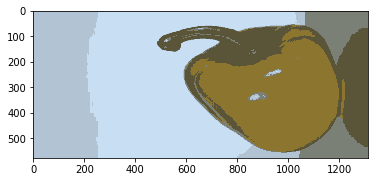

In [175]:
#Run 2 - Creates label matrix that segments image using k means clustering 

from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

n_clusters = 5

cluster_pic1, reshaped_labels = cluster_image("/Users/rahulbalakrishnan/Desktop/test3_1.jpg", n_clusters)
# cluster_pic2, reshaped_labels = cluster_image("/Users/rahulbalakrishnan/Desktop/test4_2.jpg", n_clusters)
plt.imshow(cluster_pic1)

ranked_ranks = []
for rank in range(n_clusters): 
    ranked_ranks.append(len(reshaped_labels[reshaped_labels==rank]))
ranked_ranks = np.array(ranked_ranks)

In [176]:
#Run 3 - Sets cache for boundary positions

boundary_positions = []
for row_index in range(len(reshaped_labels)): 
    for col_index in range(len(reshaped_labels[0])): 
        nearby_items = nearby_iterator(row_index, col_index, reshaped_labels)
        current_label = reshaped_labels[row_index][col_index]
        for item in nearby_items: 
            if item[0] != current_label: 
                boundary_positions.append((row_index, col_index))
                break

In [177]:
#Run 4 - Create spectra permutation iterator and find best spectral selector permutation 

iterator = generate_combinations(np.empty(shape=(n_clusters,)), 0)

best_lum_diff = None
best_permutation = None
count = 0
for permutation in iterator: 
    
    lum_dif_across_boundaries = measure_luminance_diff_across_boundaries(luminance_matrix1, 
                                             luminance_matrix2, 
                                             reshaped_labels, 
                                             np.array(boundary_positions), 
                                             permutation,
                                             ranked_ranks)
    if not best_lum_diff or lum_dif_across_boundaries > best_lum_diff: 
        best_lum_diff = lum_dif_across_boundaries
        best_permutation = np.copy(permutation)
    count += 1
    if(count %100 == 0): 
        print("Done with {} permutations".format(count))
print("Done with all {} permutations".format(count))   

Done with all 32 permutations


In [178]:
#Run 5 - Remap each pixel according to its label and the best permutation

shape = np.shape(pixel_grid1)
pixel_grid_final = np.zeros(shape=(shape[0], shape[1], 3), dtype=float)
for row_index in range(len(pixel_grid1)):
        for col_index in range(len(pixel_grid1[row_index])):
            label = reshaped_labels[row_index][col_index]
            r1,g1,b1 = cluster_pic1[row_index][col_index]
#             r2,g2,b2 = cluster_pic2[row_index][col_index]
            if best_permutation[label] == 1: 
#             if luminance_matrix1[row_index][col_index] > luminance_matrix2[row_index][col_index]:
#             if luminance(r1,g1,b1) > luminance(r2,g2,b2):
                pixel_grid_final[row_index][col_index] = pixel_grid1[row_index][col_index]
            else: 
                pixel_grid_final[row_index][col_index] = pixel_grid2[row_index][col_index]
                
# shape = np.shape(pixel_grid1)
# pixel_grid_final = np.zeros(shape=(shape[0], shape[1], 3), dtype=float)
# for row_index in range(len(pixel_grid1)):
#         for col_index in range(len(pixel_grid1[row_index])):
#             label = reshaped_labels[row_index][col_index]
#             r1,g1,b1 = cluster_pic1[row_index][col_index]
# #             r2,g2,b2 = cluster_pic2[row_index][col_index]
#             pixel_grid_final[row_index][col_index] = .5 * pixel_grid1[row_index][col_index] + .5*pixel_grid2[row_index][col_index]

In [179]:
#Run 6 - Write hyperspectral image to disk 

pixel_grid_final_output = pixel_grid_final.astype("uint8")
img = Image.fromarray(pixel_grid_final_output)
img.save("/Users/rahulbalakrishnan/Desktop/test3_10.jpg")

In [ ]:
with h5py.File("/Users/rahulbalakrishnan/Desktop/pool.mat", 'r') as f:
        wavelengths = f["Wavelengths"][0]
        data = f["S"][0]
        shape = np.shape(data)
        for n in range(shape[0] * shape[1] * 3): 
            data[100][100]


In [ ]:
lum_dif_across_boundaries = measure_luminance_diff_across_boundaries(luminance_matrix1, 
                                             luminance_matrix2, 
                                             reshaped_labels, 
                                             np.array(boundary_positions), 
                                             np.array([0,1,0,1,1,0,101,0,0]))
print(lum_dif_across_boundaries)

In [ ]:
best_lum_diff

In [ ]:
best_permutation

In [ ]:
with h5py.File("/Users/rahulbalakrishnan/Desktop/Scene83_2500.mat", 'r') as f:
        wavelengths = f["Wavelengths"][0]
        shape = f["S"].shape
        array = f["S"][0]
#         temp_grid = np.zeros(shape=(shape[1], shape[2], 3))
#         hyper_sum_wavelength_over_pixels(array, 0, wavelengths, len(wavelengths), temp_grid, np.array(evaluate_fit_function_curve2(wavelengths[0]))) 
                                         
print(array)
                                    

In [24]:
pixel_grid_temp = np.copy(pixel_grid1)

for rowIndex in range(len(pixel_grid_temp)): 
    for colIndex in range(len(pixel_grid_temp[0])): 
        for colorIndex in range(3): 
            original_value = pixel_grid_temp[rowIndex][colIndex][colorIndex]
            pixel_grid_temp[rowIndex][colIndex][colorIndex] = min(original_value*1.2 + 60, 255)

pixel_grid1_temp_output = pixel_grid_temp.astype("uint8")
img = Image.fromarray(pixel_grid1_temp_output)
img.save("/Users/rahulbalakrishnan/Desktop/test7_4.jpg")

In [8]:
a = np.copy(pixel_grid1)
a = a.reshape(a.shape[0]*a.shape[1], a.shape[2])
print(a)
print(a[:,0])
print(np.quantile(a, .9))

[[53.45751626 53.54541882 60.44227754]
 [53.77219457 53.84305322 60.4783944 ]
 [53.99819266 53.94105735 60.89789229]
 ...
 [13.45761606 13.22498754 14.61343699]
 [13.17812042 13.24550741 15.15229198]
 [13.64579127 13.53538664 15.179588  ]]
[53.45751626 53.77219457 53.99819266 ... 13.45761606 13.17812042
 13.64579127]
132.33256176457172


In [36]:
temp = norm_pixel_grid2(pixel_grid1_temp, .9)
temp_output = temp.astype("uint8")
img = Image.fromarray(temp_output)
img.save("/Users/rahulbalakrishnan/Desktop/test7_4.jpg")

3076460

In [41]:
len(boundary_positions)

337896

In [52]:
print(np.shape(reshaped_labels))
print(np.shape(pixel_grid1))

(1312, 2090)
(2090, 1312, 3)


In [99]:
best_permutation

array([0., 0., 1., 1., 1., 0., 0.])

In [131]:
pixel_grid2

array([[[165.58347422, 179.71290465, 197.62446548],
        [165.6955817 , 179.8884167 , 198.67624547],
        [165.82892012, 179.90547772, 197.5989053 ],
        ...,
        [109.11726655, 116.47363964, 121.58144651],
        [109.27091439, 116.77295272, 122.27189111],
        [109.09774913, 116.52549742, 121.517126  ]],

       [[165.20975007, 179.36293385, 196.66081074],
        [165.7916909 , 179.90824826, 198.29824079],
        [165.642595  , 179.67817328, 197.46142716],
        ...,
        [108.81885852, 116.29209211, 121.38139912],
        [109.1679887 , 116.62638963, 121.5821906 ],
        [109.01836067, 116.43921908, 121.67580872]],

       [[165.5235255 , 179.6013958 , 197.51986516],
        [165.82190779, 179.96902287, 198.33388616],
        [165.47701371, 179.75665032, 198.21563143],
        ...,
        [109.1856007 , 116.60487231, 121.55780569],
        [109.18138699, 116.69385907, 121.81703245],
        [109.01430624, 116.4951469 , 121.70410854]],

       ...,

      

In [168]:
luminance_matrix1[450][1000]

118.0

In [169]:
luminance_matrix2[450][1000]

126.0

In [161]:
ranked_ranks

array([ 48877,  96215,  73981,  62988, 228518,  96368,  19283,  23740,
       100553,   6501])